In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.path import Path as PATH
from matplotlib.patches import PathPatch
import numpy as np
import ipywidgets
from pathlib import Path
import pandas as pd
from scipy.stats import binned_statistic_2d
from functions import *
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from functions import get_SAA_mask, plot_function, apply_filters, bin_data, circle_points
import os
from shapely.geometry import Polygon
from pyproj import Transformer

In [2]:
output_folder = Path.cwd()/"plots"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Read data

In [3]:
cwd = Path.cwd()
filename = cwd / "pkl_files/data_combined_2020_03_19_to_2025_01_01.pkl"
data_file = Path(filename)

all_data = pd.read_pickle(data_file)

### Add percent/sec

In [4]:
# Can be removed once this is part of the main computation
if 'percentage_cosmics_per_s' not in all_data.columns:
    all_data['percentage_cosmics_per_s'] = all_data['percentage_cosmics']/all_data['exp_time']

# MAP

In [5]:
# Read SAA mask
SAA_previous_mask2D, lat_SAA2D, lon_SAA2D, SAA_previous_mask1D, lat_SAA1D, lon_SAA1D, lat_min, lat_max, lon_min, lon_max = get_SAA_mask("CH_TU2024-01-16T15-06-00_EXT_APP_SAAMap-690km_V0301.fits")
SAA_pre_LTAN_mask2D, lat_SAA2D, lon_SAA2D, SAA_pre_LTAN_mask1D, lat_SAA1D, lon_SAA1D, _, _, _, _ = get_SAA_mask("CH_TU2020-03-11T00-00-00_EXT_APP_SAAMap-700km_V0102.fits")   
SAA_mask2D, lat_SAA2D, lon_SAA2D, SAA_mask1D, lat_SAA1D, lon_SAA1D, _, _, _, _ = get_SAA_mask("CH_TU2024-11-16T12-00-00_EXT_APP_SAAMap-690km_V0302.fits")   

### Apply filters

In [ ]:
map_data = all_data.copy()

## SELECT PROJECTION ##
# Use PolarStereo for the poles

# projection = ccrs.PlateCarree(-50) # -> if changed, no difference in coordinated
# projection = ccrs.Orthographic(0, -90) # South Pole
# projection = ccrs.Orthographic(0, 90) # North Pole
# projection = ccrs.NorthPolarStereo()
projection = ccrs.SouthPolarStereo()
# projection = ccrs.Orthographic(-42, -26) # SAA_center
# projection = ccrs.LambertAzimuthalEqualArea()

# color_map = 'hot_r'
color_map = 'magma_r'
figsize = (12, 8)

south_mag_pole_coord = [107.3,-80.7] # from 2020, geomagnetic south pole 
north_mag_pole_coord = [-72.7,80.7] # from 2020, geomagnetic south pole 
# projection = ccrs.Orthographic(south_mag_pole_coord[0],south_mag_pole_coord[1]) # South Pole

## APPLY FILTER TO DATA ##
# Custom filters

# Keep only SAA visits 
start_AO1 = pd.Timestamp("2020-02-01 12:00:00", tz = 'UTC')
start_AO2 = pd.Timestamp("2021-03-26 12:00:00", tz = 'UTC')
start_AO3 = pd.Timestamp("2022-07-01 12:00:00", tz = 'UTC')
start_AO4 = pd.Timestamp("2023-09-25 12:00:00", tz = 'UTC')
start_AO5 = pd.Timestamp("2024-10-01 12:00:00", tz = 'UTC')
start_LTAN = pd.Timestamp("2023-09-21 12:00:00", tz = 'UTC') # start of LTAN campaign
end_LTAN = pd.Timestamp("2023-12-20 12:00:00", tz = 'UTC') # end of LTAN campaign

# 2023 SAA #
# start_date = pd.Timestamp("2024-11-01 00:00:00", tz = 'UTC')
# end_date = pd.Timestamp("2024-11-16 00:00:00", tz = 'UTC')

# 2024 SAA #
# start_date = pd.Timestamp("2024-01-01 00:00:00", tz = 'UTC')
# end_date = pd.Timestamp("2025-01-01 00:00:00", tz = 'UTC')

# 2024 activity peak #
# start_date = pd.Timestamp("2024-05-08 00:00:00", tz = 'UTC')
# end_date = pd.Timestamp("2024-05-21 00:00:00", tz = 'UTC')

#start_date = pd.Timestamp("2024-01-01 00:00:00", tz = 'UTC') # start of LTAN campaign
#end_date = pd.Timestamp("2025-01-01 00:00:00", tz = 'UTC') # end of LTAN campaign

# start_date = all_data.time.min()
# end_date = all_data.time.max()

start_date = pd.Timestamp("2022-01-01 00:00:00", tz = 'UTC')
end_date = pd.Timestamp("2023-01-01 00:00:00", tz = 'UTC')

# Apply filters

filters = ['time-','time+','no_straylight','percentage_cosmics','latitude-','latitude+']#,'percentage_cosmics_per_s']#,'percentage_cosmics']#,'percentage_cosmics_per_s']#,'latitude-','latitude+']#,'no_straylight','largest_cosmics','percentage_cosmics']
values = [start_date, end_date, 0, 50, -90, -50]#, 0.1]#,300]#,-45,-10]#,None, 150, 17]
reverse_filters = [False, False, False, False, False, False]#, False]#, True]#, False]#, True]#,False, False]#, False]
map_data = apply_filters(map_data,filters,values,reverse_filters)

nb_visits = len(np.unique(map_data.visit_ID))
nb_SAA_visits = len(np.unique(map_data[map_data.visit_ID.str[:6] == '34_102'].visit_ID))

print(f"\nVisits go from {map_data.time.min().strftime('%d-%b-%Y')} to {map_data.time.max().strftime('%d-%b-%Y')}")
print(f"There are {nb_visits} in total, including {nb_SAA_visits} SAA visits")

data_plot = map_data

x_values = 'LONGITUDE'
y_values ='LATITUDE'
# hue_values = 'density_cosmics'
# hue_values = 'percentage_cosmics'
hue_values = 'percentage_cosmics_per_s'

### For 2020 M&C, remove the problematic following visits:

# The one with very low CR in the SAA (black images) and the ones with very large unfiltered straylight (CR_percent_per_s > 2)
# The one with very low CR in the SAA (black images) and the ones with very large unfiltered straylight (CR_percent_per_s > 2)
# remove = ['30_1_1_1 ','30_1_4_1 ','30_41_10_1 ','30_41_35_1','30_48_24_2','30_15_12_1','30_15_12_2','30_17_8_1','30_1_1_1','30_1_4_1',
#             '30_1_7_1','30_1_8_1','30_20_8_1','30_27_2_1','30_27_3_1','30_35_1_1','30_35_2_1',
#             '30_35_5_1','30_35_6_1','30_36_10_1','30_41_10_1','30_41_12_1','30_41_1_1',
#             '30_41_35_1','30_41_36_1','30_41_42_1','30_41_43_1','30_41_45_1','30_50_1_1']

# for ID in remove:
#    data_plot = data_plot[data_plot['visit_ID'] != ID]
    
# print(f"Removed the manually input visits: {remove}")    



Keep data > 2021-01-01 00:00:00+00:00
Removed 151528 data points, kept 1513849
Keep data < 2023-01-01 00:00:00+00:00
Removed 750559 data points, kept 763290
Keep data only not affected with straylight
Removed 31588 data points, kept 731702
Keep data images with < 50% of pixels affected by cosmics
Removed 378 data points, kept 731324
Kepp data with latitude > -90
Removed 0 data points, kept 731324
Keep with latitude < -50
Removed 590699 data points, kept 140625

Visits go from 09-Jan-2021 to 31-Dec-2022
There are 1608 in total, including 0 SAA visits


### Single map

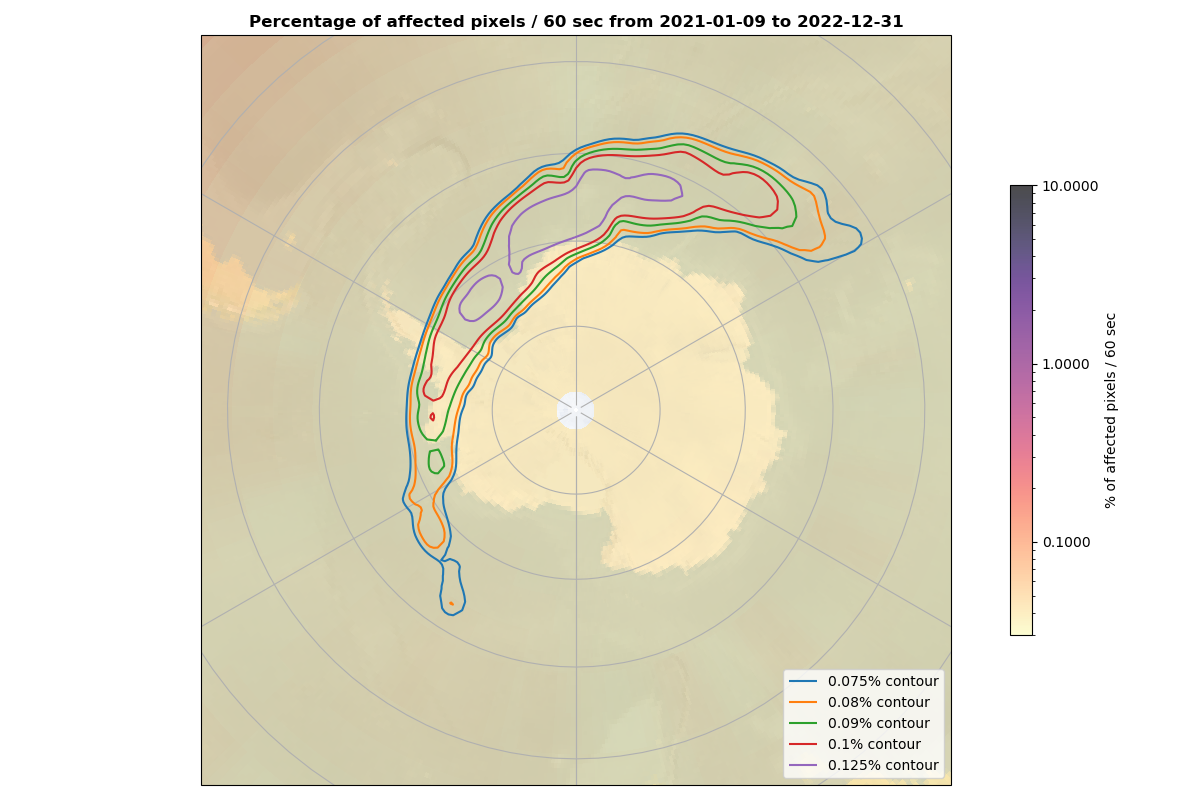

['0.075% contour (deg²):', 1767.5639618493744, '0.08% contour (deg²):', 1501.1012590813189, '0.09% contour (deg²):', 1074.784554257244, '0.1% contour (deg²):', 803.3429036341566, '0.125% contour (deg²):', 276.07135993494205]
['0.075% contour (km²):', 10211519.53481275, '0.08% contour (km²):', 8584846.716160623, '0.09% contour (km²):', 6178180.364755818, '0.1% contour (km²):', 4645913.528299939, '0.125% contour (km²):', 1603497.9697112192]
['0.075% contour, NESW coordinates :', (-51.45684837204269, 60.230861491977294, -78.04922958404488, -150.32545889537838), '0.08% contour, NESW coordinates :', (-53.04941055757507, 56.17249317220053, -77.57484220170711, -147.6426735849816), '0.09% contour, NESW coordinates :', (-54.7507047838575, 49.5602750818814, -76.60581259034888, -114.58262968321057), '0.1% contour, NESW coordinates :', (-55.57579190429841, 45.08092376666106, -75.84482348229697, -94.1286242940692), '0.125% contour, NESW coordinates :', (-60.67865759337968, 26.3633676175347, -74.275

In [ ]:
bin = True
#polar_view = True #polar view uses different interpolation function -> to be used with PolarStereo projection
# Interpolation level, can be 'None', 'base_grid' or 'fine_grid'
if bin:  
    interp_grid_size = 1
log_plot = True

%matplotlib widget
plt.close('all')
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection)
ax.set_extent([-5e6, 5e6, 5e6, -5e6], crs=projection) #to constrain polar field of view
ax.stock_img()
ax.gridlines()
legend_items = []
legend_labels = []

# Plot SAA contour
# SAA_current = plt.contour(lon_SAA2D,lat_SAA2D,SAA_mask2D, colors = 'k', linestyles ='dashed', linewidths = 2,  alpha = 0.3,levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
# h1,_ = SAA_current.legend_elements()
# legend_items.append(h1[0])
# legend_labels.append('Current mask')

# SAA_new = plt.contour(lon_SAA2D,lat_SAA2D,SAA_previous_mask2D, colors = 'grey', linewidths = 2,  alpha = 1,levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
# h1,_ = SAA_new.legend_elements()
# legend_items.append(h1[0])
# legend_labels.append('Mask before 16th November 2024')


x = data_plot[x_values]
y = data_plot[y_values]
c = data_plot[hue_values]*60


# set min and max values of the contour percentages
vmin = 0.03
vmax = 10

# if coordiantes should be constrained, specify here, otherwise set to None
latitude_min = -90
latitude_max = -50
longitude_min = None
longitude_max = None

if bin:
    binned_data, _, _, lon_data, lat_data  = bin_data_polar(x,y,c, interp_grid_size=interp_grid_size, lon_min = longitude_min, lon_max = longitude_max, lat_min = latitude_min, lat_max = latitude_max, type = hue_values)
    if log_plot:
        SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, norm = LogNorm(vmin, vmax), transform=ccrs.PlateCarree()) 
    else :
        SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax) 
else:
    if log_plot:
        SAA_map_plot = ax.scatter(x,y,c = c, s = 15, alpha = 0.7, marker = 'o', norm=LogNorm(vmin, vmax), cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
    else:
        SAA_map_plot = ax.scatter(x,y,c = c, s = 15, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic(), vmin=vmin, vmax=vmax)#, label = labels[i]) 

# if polar_view:
#     if bin:
#         binned_data, _, _, lon_data, lat_data  = bin_data_polar(x,y,c, interp_grid_size=interp_grid_size, type = hue_values)
#         if log_plot:
#             SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, norm = LogNorm(vmin, vmax), transform=ccrs.PlateCarree()) 
#         else :
#             SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax) 
#     else:
#         if log_plot:
#             SAA_map_plot = ax.scatter(x,y,c = c, s = 15, alpha = 0.7, marker = 'o', norm=LogNorm(vmin, vmax), cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
#         else:
#             SAA_map_plot = ax.scatter(x,y,c = c, s = 15, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic(), vmin=vmin, vmax=vmax)#, label = labels[i]) 
# else:
#     if bin:
#         binned_data, _, _, lon_data, lat_data  = bin_data(x,y,c, interp_grid_size=interp_grid_size, type = hue_values)
#         if log_plot:
#             SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, norm = LogNorm(vmin, vmax), transform=ccrs.PlateCarree()) 
#         else :
#             SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax) 
#     else:
#         if log_plot:
#             SAA_map_plot = ax.scatter(x,y,c = c, s = 15, alpha = 0.7, marker = 'o', norm=LogNorm(vmin, vmax), cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
#         else:
#             SAA_map_plot = ax.scatter(x,y,c = c, s = 15, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic(), vmin=vmin, vmax=vmax)#, label = labels[i]) 

# Plot contour   
# if bin: 
#     for i, contour_level in enumerate([0.05,0.1,0.2,0.5,1]):
#         color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i + 1*i]
#         contour = plt.contour(lon_data,lat_data, binned_data, levels=[contour_level],  linewidths = 1.5, origin='lower', colors = 'green', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
#         h,_ = contour.legend_elements()
#         legend_items.append(h[0])
#         legend_labels.append(f"{contour_level}% contour")

if bin:
    coordinates = []
    area_contours_deg = []
    area_contours_km = []
    perimeter_kms = []
    results = []         
    for i, contour_level in enumerate([0.075, 0.08, 0.09, 0.1, 0.125]): # 0.1, 1, 2, 5, 10 SAA| 0.075, 0.08, 0.09, 0.1, 0.125 South Pole| 
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
        # contour = plt.contour(lon_data, lat_data, binned_data, levels=[contour_level], origin='lower', colors = color, extent=(lon_min, lon_max, -lat_min, lat_max),transform=ccrs.PlateCarree())
        contour = plt.contour(lon_data, lat_data, binned_data, levels=[contour_level], origin='lower', colors = color, extent=(longitude_min, longitude_max, latitude_min, latitude_max),transform=ccrs.PlateCarree())
        h,_ = contour.legend_elements()
        legend_items.append(h[0])
        legend_labels.append(f"{contour_level}% contour")

        orbit_height = 700000 # in m
        radius_earth = 6378000
        radius_total = orbit_height + radius_earth

        paths = contour.get_paths()

        area_deg = area_in_degrees(paths)
        area_contours_deg.append(f"{contour_level}% contour (deg²):")
        area_contours_deg.append(area_deg)

        perimeter_km, area_km = area_in_kilometres(paths, radius_total)
        area_contours_km.append(f"{contour_level}% contour (km²):")
        area_contours_km.append(area_km)

        perimeter_kms.append(f"{contour_level}% perimeter (km):")
        perimeter_kms.append(perimeter_km)

        coords = location_change(paths)
        coordinates.append(f"{contour_level}% contour, NESW coordinates :")
        coordinates.append(coords)


if hue_values == 'percentage_cosmics':
    unit = 'Percentage of affected pixels'
    name_file_start = "per_CR_"
    cbar = plt.colorbar(SAA_map_plot, label = '% of affected pixels', shrink=0.6)
    cbar.formatter = FormatStrFormatter("%.4f")
    cbar.update_ticks()
elif hue_values == 'percentage_cosmics_per_s':
    name_file_start = "per_CR_s_"
    unit = 'Percentage of affected pixels / 60 sec'
    cbar = plt.colorbar(SAA_map_plot, label = '% of affected pixels / 60 sec', shrink=0.6,)
    cbar.formatter = FormatStrFormatter("%.4f")
    cbar.update_ticks()
else:
    name_file_start = "CR_density_"
    unit = 'Density of cosmics'
    cbar = plt.colorbar(SAA_map_plot, label = 'hits/cm2/s', shrink=0.6)

# /

plt.legend(legend_items, legend_labels, loc = 'lower right')
title = f"{unit} from " + data_plot.time.min().strftime('%Y-%m-%d') + ' to ' + data_plot.time.max().strftime('%Y-%m-%d')
# title =  f"{v_id} | {data_visit['target_name']}"
plt.title(title, weight = 'bold')
fileout_name =  name_file_start + data_plot.time.min().strftime('%Y-%m-%d') + "_to_" + data_plot.time.max().strftime('%Y-%m-%d')+ "_new_correction_sec_2023.png"
#fileout_name = "map_SAA_no_mask.png"#SAA_since_01_10.png"
plt.tight_layout()
#plt.savefig(output_folder / fileout_name, transparent = False, dpi = 600,format = 'png')

plt.show()
print(area_contours_deg)
print(area_contours_km)
#print(perimeter_kms)
print(coordinates)


### Map with Slider

In [ ]:
bin = True
polar = True
# Interpolation level, can be 'None', 'base_grid' or 'fine_grid'
interpolation = 'base_grid' 
log_plot = True

# Time between frames
time_resolution =  pd.Timedelta(weeks= 1)
nb_maps = int(np.ceil((end_date - start_date)/time_resolution))


def update_data(idx):
    start = start_date + time_resolution*int(idx)
    end  = start_date + time_resolution*(int(idx)+1)
    data_between_dates = data_plot[(data_plot.time > start) & (data_plot.time < end)]
    
    x = data_between_dates[x_values]
    y = data_between_dates[y_values]
    c = data_between_dates[hue_values]
    
    SAA_current = plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'grey', linewidths = 2,  alpha = 1,levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
    
    
    #plt.scatter(south_mag_pole_coord[0], south_mag_pole_coord[1], s = 100, marker = 'X', transform=ccrs.PlateCarree(), label = "South magnetic pole")
    #circle_lat, circle_lon = circle_points(south_mag_pole_coord[1], south_mag_pole_coord[0], 23.44, num_points=120)
    #plt.plot(circle_lon, circle_lat, transform=ccrs.PlateCarree())

    binned_data, _, _, _, _  = bin_data(x,y,c, interpolation=interpolation, type = hue_values)

    return start,end,binned_data    


fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection)
ax.stock_img()
ax.gridlines()

# Plot SAA contour
SAA_current = plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'grey', linewidths = 2,  alpha = 1,levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
h1,_ = SAA_current.legend_elements()
legend_items.append(h1[0])
legend_labels.append('Current mask')

# Plot initial data
x = data_plot[x_values]
y = data_plot[y_values]
c = data_plot[hue_values]

if bin:
    binned_data, _, _, lon_data, lat_data  = bin_data(x,y,c, interpolation=interpolation, type = hue_values)
    if log_plot:
        SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, norm = LogNorm(), transform=ccrs.PlateCarree()) 
    else :
        SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, transform=ccrs.PlateCarree()) 
else:
    if log_plot:
        SAA_map_plot = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', norm=LogNorm(), cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
    else:
        SAA_map_plot = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i]) 
        
# Plot contour    
for i, contour_level in enumerate([0.1,1,5]):
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
    contour = plt.contour(lon_data, lat_data, binned_data, levels=[contour_level], origin='lower', colors = color, extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
    h,_ = contour.legend_elements()
    legend_items.append(h[0])
    legend_labels.append(f"{contour_level}% contour")

if hue_values == 'percentage_cosmics':
    unit = 'Percentage of affected pixels'
    name_file_start = "per_CR_"
    cbar = plt.colorbar(SAA_map_plot, label = '% of affected pixels', shrink=0.6)
    cbar.formatter = FormatStrFormatter("%.4f")
    cbar.update_ticks()
elif hue_values == 'percentage_cosmics_per_s':
    name_file_start = "per_CR_s_"
    unit = 'Percentage of affected pixels / s'
    cbar = plt.colorbar(SAA_map_plot, label = '% of affected pixels / sec', shrink=0.6)
    cbar.formatter = FormatStrFormatter("%.4f")
    cbar.update_ticks()
else:
    name_file_start = "CR_density_"
    unit = 'Density of cosmics'
    cbar = plt.colorbar(SAA_map_plot, label = 'hits/cm2/s', shrink=0.6)


def plotimg(idx):
    
    ax.clear()
    ax.stock_img()
    ax.gridlines()
    # start = start_date + time_resolution*int(idx)
    # end  = start_date + time_resolution*(int(idx)+1)
    # data_between_dates = data_plot[(data_plot.time > start) & (data_plot.time < end)]
    
    # x = data_between_dates['LONGITUDE']
    # y = data_between_dates['LATITUDE']
    # c = data_between_dates['density_cosmics']
    start,end, binned_data = update_data(idx)
    if logscale:
        cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), norm = LogNorm(), transform=ccrs.PlateCarree()) 
        #cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, norm=LogNorm(), marker = 'o', cmap='hot_r', transform=ccrs.Geodetic())#, label = labels[i])
    else:
        cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), transform=ccrs.PlateCarree()) 
        # cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i]
    ax.set_title('Cosmic Rays density from ' + start.strftime('%d-%b-%Y') + ' to ' + end.strftime('%d-%b-%Y'), weight = 'bold')

ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=nb_maps-1,step=1))
plt.show()

# Animation

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def update_data(idx):
    start = start_date + time_resolution*int(idx)
    end  = start_date + time_resolution*(int(idx)+1)
    data_between_dates = data_plot[(data_plot.time > start) & (data_plot.time < end)]
    
    x = data_between_dates[x_values]
    y = data_between_dates[y_values]
    c = data_between_dates[hue_values]
    
    plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'white', linewidths = 2, levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
    # plt.scatter(south_mag_pole_coord[0], south_mag_pole_coord[1], s = 100, marker = 'X', transform=ccrs.PlateCarree(), label = "South magnetic pole")
    # circle_lat, circle_lon = circle_points(south_mag_pole_coord[1], south_mag_pole_coord[0], 23.44, num_points=120)
    # plt.plot(circle_lon, circle_lat, transform=ccrs.PlateCarree())

    binned_data, _, _, _, _  = bin_data(x,y,c, interpolation=interpolation, type = hue_values)
    print(f"Creating image {int(idx)}/{nb_maps}")

    return start,end,binned_data   

# Assuming plotimg is your function that plots the image based on the idx
# We'll rewrite plotimg slightly to work with FuncAnimation
def plotimg(idx):
    
    ax.clear()
    ax.stock_img()
    ax.gridlines()
    # start = start_date + time_resolution*int(idx)
    # end  = start_date + time_resolution*(int(idx)+1)
    # data_between_dates = data_plot[(data_plot.time > start) & (data_plot.time < end)]
    
    # x = data_between_dates['LONGITUDE']
    # y = data_between_dates['LATITUDE']
    # c = data_between_dates['density_cosmics']
    start,end, binned_data = update_data(idx)
    if logscale:
        cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), norm = LogNorm(), transform=ccrs.PlateCarree()) 
        #cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, norm=LogNorm(), marker = 'o', cmap='hot_r', transform=ccrs.Geodetic())#, label = labels[i])
    else:
        cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), transform=ccrs.PlateCarree()) 
        # cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i]
    mid_time = start + time_resolution/2
    mid_label = mid_time.strftime('%B %Y')
    ax.set_title(f"{mid_label} ", fontsize = 18, weight = 'bold')
    
    SAA_current = plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'k', linewidths = 3,  alpha = 1,levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
    # h3,_ = SAA_current.legend_elements()
    # if hue_values == 'percentage_cosmics':
    #     cbar = plt.colorbar(SAA_map_plot, label = '% of affected pixels', shrink=0.6)
    #     cbar.formatter = FormatStrFormatter("%.2f")
    #     cbar.update_ticks()
    # else:
    #     cbar = plt.colorbar(SAA_map_plot, label = 'hits/cm2/s', shrink=0.6)
    # plt.legend([h3[0]], ['Current mask'])

# Animation function to update the plot
def update(frame):
    plotimg(frame)

# Create a figure for the animation
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection)
ax.stock_img()
ax.gridlines()

interpolation = 'None' 
# interpolation = 'base_grid' 
# interpolation = 'fine_grid' 

# Time between frames
logscale = True
time_resolution =  pd.Timedelta(weeks= 2)
nb_maps = int(np.ceil((end_date - start_date)/time_resolution))

# Create the animation
ani = FuncAnimation(fig, update, frames=nb_maps, repeat=True)

# Save the animation as an mp4 file without displaying
ani.save('animation.gif', writer='ffmpeg', fps=10)  # Adjust fps as needed

# Sum CR hits under SAA

In [ ]:
# Get data in the rectangle
lat_n = -48
lat_s = -71
lon_w = -60
lon_e = 35

filter_rect = (data_plot[y_values] < lat_n) & (data_plot[y_values] > lat_s) & (data_plot[x_values] < lon_e) & (data_plot[x_values] > lon_w)
data_area_under_SAA = data_plot[filter_rect]

time_resolution =  pd.Timedelta(weeks=2)
nb_maps = int(np.ceil((end_date - start_date)/time_resolution))

time = np.array([])
mean_density_cosmics = np.array([])
mean_percentage = np.array([])
max_percentage = np.array([])

for i in range(nb_maps-1):
    start = start_date + time_resolution*i
    end  = start_date + time_resolution*(i+1)
    mid_time = start + time_resolution/2
    # mid_label = start.strftime('%B %Y')
    
    data_between_dates = data_area_under_SAA[(data_area_under_SAA.time > start) & (data_area_under_SAA.time < end)]

    if len(data_between_dates) == 0:
        time = np.append(time,mid_time)
        mean_density_cosmics = np.append(mean_density_cosmics,np.nan)
    else:
        # Data binned at 5*5
        x = data_between_dates[x_values]
        y = data_between_dates[y_values]
        binned_density, _, _, _, _ = bin_data(x,y,data_between_dates['density_cosmics'], interpolation='None', type = 'density_cosmics')
        binned_percentage, _, _, _, _ = bin_data(x,y,data_between_dates['percentage_cosmics'], interpolation='None', type = 'percentage_cosmics')
        time = np.append(time,mid_time)
        mean_density_cosmics = np.append(mean_density_cosmics,np.nanmean(binned_density))
        max_percentage = np.append(max_percentage,np.nanmax(binned_percentage))
        mean_percentage = np.append(mean_percentage,np.nanmean(binned_percentage))
        
# # Save array
# timestamps_str = np.array([ts.isoformat() for ts in time])
# combined_array = np.column_stack((timestamps_str, mean_density_cosmics))
# np.savetxt('1month.csv', combined_array, delimiter=',', header='Timestamp,Data', comments='', fmt='%s')

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


# Assuming plotimg is your function that plots the image based on the idx
# We'll rewrite plotimg slightly to work with FuncAnimation
def plotimg(idx):
    
    ax.clear()
    ax.plot(time,mean_density_cosmics)
    ax.set_ylabel(f'Mean CR hits in region (hits/cm2/s)', weight = 'bold')
    # ax.axvline(start_AO1, c='C5', label = 'AO-1')
    # ax.axvline(start_AO2, c='C1', label = 'AO-2')
    # ax.axvline(start_AO3, c='C2',label = 'AO-3')
    # ax.axvline(start_AO4, c='C3', label = 'AO-4')
    # ax.axvline(start_AO5, c='C4',label = 'AO-5')
    ax.axvline(pd.Timestamp("2021-01-01 12:00:00", tz = 'UTC'), c='C5', label = '2021')
    ax.axvline(pd.Timestamp("2022-01-01 12:00:00", tz = 'UTC'), c='C1', label = '2022')
    ax.axvline(pd.Timestamp("2023-01-01 12:00:00", tz = 'UTC'), c='C2',label = '2023')
    ax.axvline(pd.Timestamp("2024-01-01 12:00:00", tz = 'UTC'), c='C3', label = '2024')
    ax.axvline(time[idx], linewidth = 1, color = 'k')
    ax.legend()
    # ax.tight_layout()

# Animation function to update the plot
def update(frame):
    plotimg(frame)

# Create a figure for the animation
fig,ax = plt.subplots(figsize = (8,4))

time_resolution =  pd.Timedelta(weeks= 2)
nb_maps = int(np.ceil((end_date - start_date)/time_resolution))

# Create the animation
ani = FuncAnimation(fig, update, frames=nb_maps-1, repeat=True)

# Save the animation as an mp4 file without displaying
ani.save('animated_plot_mean_cr_hits.gif', writer='ffmpeg', fps=10)  # Adjust fps as needed

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt

start_AO1 = pd.Timestamp("2020-02-01 12:00:00", tz = 'UTC')
start_AO2 = pd.Timestamp("2021-03-26 12:00:00", tz = 'UTC')
start_AO3 = pd.Timestamp("2022-07-01 12:00:00", tz = 'UTC')
start_AO4 = pd.Timestamp("2023-09-25 12:00:00", tz = 'UTC')
start_AO5 = pd.Timestamp("2024-10-01 12:00:00", tz = 'UTC')

# # Read the CSV file into a DataFrame
# df = pd.read_csv('1month.csv', delimiter=',')
# time = pd.to_datetime(df['Timestamp'])
# mean_density_cosmics = pd.to_numeric(df['Data'])

fig,ax = plt.subplots(figsize = (8,4))
ax.plot(time,mean_density_cosmics)
ax.tick_params(axis='x', rotation=0) 
ax.set_ylabel(f'Mean CR hits in region (hits/cm2/s)')
ax.axvline(start_AO1, c='C0', label = 'AO-1')
ax.axvline(start_AO2, c='C1', label = 'AO-2')
ax.axvline(start_AO3, c='C2',label = 'AO-3')
ax.axvline(start_AO4, c='C5', label = 'AO-4')
ax.axvline(start_AO5, c='C4',label = 'AO-5')

ax.legend(loc = 'upper left')
plt.tight_layout()

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt

start_AO1 = pd.Timestamp("2020-02-01 12:00:00", tz = 'UTC')
start_AO2 = pd.Timestamp("2021-03-26 12:00:00", tz = 'UTC')
start_AO3 = pd.Timestamp("2022-07-01 12:00:00", tz = 'UTC')
start_AO4 = pd.Timestamp("2023-09-25 12:00:00", tz = 'UTC')
start_AO5 = pd.Timestamp("2024-10-01 12:00:00", tz = 'UTC')

# # Read the CSV file into a DataFrame
# df = pd.read_csv('1month.csv', delimiter=',')
# time = pd.to_datetime(df['Timestamp'])
# mean_density_cosmics = pd.to_numeric(df['Data'])

fig,ax = plt.subplots(figsize = (8,4))
ax.plot(time,mean_percentage)
ax.tick_params(axis='x', rotation=0) 
ax.set_ylabel(f'Mean percentage of affected pixels')
ax.axvline(start_AO1, c='C0', label = 'AO-1')
ax.axvline(start_AO2, c='C1', label = 'AO-2')
ax.axvline(start_AO3, c='C2',label = 'AO-3')
ax.axvline(start_AO4, c='C5', label = 'AO-4')
ax.axvline(start_AO5, c='C4',label = 'AO-5')

ax.legend(loc = 'upper left')
plt.tight_layout()

In [ ]:
interpolation = 'None' 
# interpolation = 'base_grid' 
# interpolation = 'fine_grid' 

# Time between frames
logscale = True
time_resolution =  pd.Timedelta(days= 1)
nb_maps = int(np.ceil((end_date - start_date)/time_resolution))

# Get data in the rectangle
lat_n = -48
lat_s = -71
lon_w = -60
lon_e = 35

filter_rect = (data_plot[y_values] < lat_n) & (data_plot[y_values] > lat_s) & (data_plot[x_values] < lon_e) & (data_plot[x_values] > lon_w)
data_filtered = data_plot[filter_rect]
    
def update_data(idx):
    start = start_date + time_resolution*int(idx)
    end  = start_date + time_resolution*(int(idx)+1)
    data_between_dates = data_filtered[(data_plot.time > start) & (data_plot.time < end)]
    
    # Data binned at 5*5
    x = data_between_dates[x_values]
    y = data_between_dates[y_values]
    c = data_between_dates[hue_values]
    binned_data, _, _, _, _ = bin_data(x,y,c, interpolation='base_grid', type = hue_values)
    
    plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'white', linewidths = 2, levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
    plt.scatter(south_mag_pole_coord[0], south_mag_pole_coord[1], s = 100, marker = 'X', transform=ccrs.PlateCarree(), label = "South magnetic pole")
    circle_lat, circle_lon = circle_points(south_mag_pole_coord[1], south_mag_pole_coord[0], 23.44, num_points=120)
    plt.plot(circle_lon, circle_lat, transform=ccrs.PlateCarree())

    binned_data, _, _, _, _  = bin_data(x,y,c, interpolation=interpolation, type = hue_values)

    return start,end,binned_data    


fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection)
ax.stock_img()
ax.gridlines()

# Plot SAA contour
plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'white', linewidths = 2, levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
plt.scatter(south_mag_pole_coord[0], south_mag_pole_coord[1], s = 100, marker = 'X', transform=ccrs.PlateCarree(), label = "South magnetic pole")
circle_lat, circle_lon = circle_points(south_mag_pole_coord[1], south_mag_pole_coord[0], 23.44, num_points=120)
plt.plot(circle_lon, circle_lat, transform=ccrs.PlateCarree())

# Data binned at 5*5
x = data_filtered[x_values]
y = data_filtered[y_values]
c = data_filtered[hue_values]
binned_filtered_data, _, _, _, _ = bin_data(x,y,c, interpolation='base_grid', type = hue_values)
   

if logscale: 
    # cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', norm=LogNorm(), cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
    cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), norm = LogNorm(), transform=ccrs.PlateCarree()) 
    # Calculate the log range for the colorbar
    # log_min = np.floor(np.log10(np.nanmin(data_plot[hue_values])+1))
    # log_max = np.round(np.log10(np.nanmax(data_plot[hue_values])),1)
    # #log_range = np.logspace(log_min, log_max, num=10)
    # log_range = np.arange(log_min, log_max, 0.5)
    # # Convert back from log scale to the original scale
    # cbar_range = 10**log_range
    # # Create a logarithmic norm for the color mapping
    # log_norm = matplotlib.colors.LogNorm(vmin=10**log_min, vmax=10**log_max)
    # # Create the colorbar with logarithmic ticks
    # colorbar = fig.colorbar(cr, ax=ax, label='hits/cm2/s', ticks=cbar_range, norm=log_norm)
    # colorbar.set_ticks(cbar_range)
    # colorbar.set_ticklabels([f'{int(tick)}' for tick in cbar_range])

else: 
    cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), transform=ccrs.PlateCarree()) 
    # cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
    # colorbar = fig.colorbar(cr, ax=ax, label = 'hits/cm2/s')#, ticks=cbar_range)

if hue_values == 'percentage_cosmics':
    cbar = plt.colorbar(cr, label = '% of affected pixels', shrink=0.6)
    cbar.formatter = FormatStrFormatter("%.2f")
    cbar.update_ticks()
else:
    cbar = plt.colorbar(cr, label = 'hits/cm2/s', shrink=0.6)

def plotimg(idx):
    
    ax.clear()
    ax.stock_img()
    ax.gridlines()
    # start = start_date + time_resolution*int(idx)
    # end  = start_date + time_resolution*(int(idx)+1)
    # data_between_dates = data_plot[(data_plot.time > start) & (data_plot.time < end)]
    
    # x = data_between_dates['LONGITUDE']
    # y = data_between_dates['LATITUDE']
    # c = data_between_dates['density_cosmics']
    start,end, binned_data = update_data(idx)
    if logscale:
        cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), norm = LogNorm(), transform=ccrs.PlateCarree()) 
        #cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, norm=LogNorm(), marker = 'o', cmap='hot_r', transform=ccrs.Geodetic())#, label = labels[i])
    else:
        cr = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, extent=(lon_min, lon_max, lat_min, lat_max), transform=ccrs.PlateCarree()) 
        # cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i]
    ax.set_title('Cosmic Rays density from ' + start.strftime('%d-%b-%Y') + ' to ' + end.strftime('%d-%b-%Y'), weight = 'bold')

ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=nb_maps-1,step=1))
plt.show()

# OTHER Plots


In [ ]:
# Data binned at 5*5
x = data_plot[x_values]
y = data_plot[y_values]
c = data_plot[hue_values]
statistic, longitudes, latitudes = bin_data(x,y,c, interpolation='base_grid', type = hue_values)

# SAA data binned at 5*5
x = data_SAA['longitude']
y = data_SAA['latitude']
c = data_SAA['SAA_FLAG']

# Bin and maks SAA mask contour
lon_min, lon_max = -180, 180
lat_min, lat_max = -90, 90

SAA_map_bins_lon = 5
SAA_map_bins_lat = 5
x_bins_SAA = np.arange(lon_min + SAA_map_bins_lon, lon_max,SAA_map_bins_lon)
y_bins_SAA = np.arange(lat_min + SAA_map_bins_lat, lat_max,SAA_map_bins_lat)

SAA_masked_binned = binned_statistic_2d(x, y, c, statistic='median', bins=[x_bins_SAA, y_bins_SAA]).statistic.T

in_SAA_lon = x_bins_SAA[np.unique(np.where(SAA_masked_binned > 0)[1])]


In [ ]:
import matplotlib.colors as mcolors
# Create a colormap
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=np.min(in_SAA_lon), vmax=np.max(in_SAA_lon))

In [ ]:
non_plotted_lon = []
min_hits = 200

fig,ax = plt.subplots()

for i in range(len(longitudes)):
    in_SAA = np.where(SAA_masked_binned[:,i] > 0)[0]
    if len(in_SAA) == 0:
        non_plotted_lon.append(longitudes[i])
        continue
    else:
        ax.plot(latitudes, statistic[:,i], color = cmap(norm(longitudes[i])), label = longitudes[i])
    # plt.yscale('log')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for the colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Longitude')
ax.set_xlabel("Latitude")
ax.set_ylabel("Hits/cm2/sec")
print(f"The following Longitudes were not plotted as the max hits/cm2/sec < {min_hits}:")
print(non_plotted_lon)

# plt.show()


In [ ]:

shift_factor_y = 20
shift_factor_x = 5

fig,ax = plt.subplots()

for i in range(len(longitudes)-1):
    in_SAA = np.where(SAA_masked_binned[:,i] > 0)[0]
    if len(in_SAA) == 0:
        non_plotted_lon.append(longitudes[i])
        continue
    else:
        #plt.plot(latitudes[:-1], statistic[i,:]- i*shift_factor, color = colors[c_i], label = longitudes[i])
        y1 = np.zeros(shape= np.shape(statistic[:,i]))- i*shift_factor_y
        y2 = statistic[:,i]- i*shift_factor_y
        plt.fill_between(latitudes[:]+shift_factor_x*i, y1, y2, where=(y2>=y1), color = cmap(norm(longitudes[i])), label = longitudes[i], alpha = 0.3)
        ind_lat_min_SAA = in_SAA[0]
        ind_lat_max_SAA = in_SAA[-1]
        #plt.plot(latitudes[ind_lat_min_SAA], statistic[i,ind_lat_min_SAA]-i*shift_factor, 'o', color = colors[c_i])
        #plt.plot(latitudes[ind_lat_max_SAA],statistic[i,ind_lat_max_SAA]-i*shift_factor, 'o', color = colors[c_i])
        plt.plot(latitudes[ind_lat_min_SAA]+shift_factor_x*i, -i*shift_factor_y, '.', color = cmap(norm(longitudes[i])), zorder = 0)
        plt.plot(latitudes[ind_lat_max_SAA]+shift_factor_x*i,-i*shift_factor_y, '.', color = cmap(norm(longitudes[i])), zorder = 0)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for the colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Longitude')
ax.set_xlabel(f"Latitude (shifted by i*{shift_factor_y})")
ax.set_ylabel(f"Hits/cm2/sec - (i*{shift_factor_y})")
print(f"The following Longitudes were not plotted as the max hits/cm2/sec < {min_hits}:")
print(non_plotted_lon)
plt.show()

In [ ]:
max_density = np.nanmax(statistic[:,:])

plt.close('all')
c_i = 0
for i in range(len(longitudes)-1):
    in_SAA = np.where(SAA_masked_binned.T[i,:] > 0)[0]
    if len(in_SAA) == 0:
        non_plotted_lon.append(longitudes[i])
        continue
    plt.figure()
    plt.plot(latitudes[:], statistic[:,i], color = cmap(norm(longitudes[i])))
    plt.axvline(latitudes[in_SAA[0]],0,statistic[:,i].max(), color = 'indianred',alpha = 0.6, label = 'SAA bounds')
    plt.axvline(latitudes[in_SAA[-1]],0,statistic[:,i].max(), color = 'indianred',alpha = 0.6)
    plt.axhline(max_density,latitudes[0],latitudes[-1], color = 'grey', alpha = 0.6, label = 'Max cosmic density value in map')
    plt.title(f"Longitude = {longitudes[i]}")
    c_i += 1
    plt.xlabel("Latitude") 
    plt.ylabel(f"Hits/cm2/sec")
    plt.legend()

print(f"The following Longitudes were not plotted as the max hits/cm2/sec < {min_hits}:")
print(non_plotted_lon)
plt.show()

# Fit gaussian to lon -57.5

In [ ]:
non_plotted_lon = []
min_hits = 200

fig,ax = plt.subplots()

for i in range(len(longitudes)):
    in_SAA = np.where(SAA_masked_binned[:,i] > 0)[0]
    if len(in_SAA) == 0:
        non_plotted_lon.append(longitudes[i])
        continue
    else:
        ax.plot(latitudes, statistic[:,i], color = cmap(norm(longitudes[i])), label = longitudes[i])
    # plt.yscale('log')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for the colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Longitude')
ax.set_xlabel("Latitude")
ax.set_ylabel("Hits/cm2/sec")
print(f"The following Longitudes were not plotted as the max hits/cm2/sec < {min_hits}:")
print(non_plotted_lon)

In [ ]:
max_density = np.nanmax(statistic[:,:])

fig,ax = plt.subplots()


plt.plot(latitudes[:], statistic[:,i], color = cmap(norm(longitudes[i])))
plt.axvline(latitudes[in_SAA[0]],0,statistic[:,i].max(), color = 'indianred',alpha = 0.6, label = 'SAA bounds')
plt.axvline(latitudes[in_SAA[-1]],0,statistic[:,i].max(), color = 'indianred',alpha = 0.6)
plt.axhline(max_density,latitudes[0],latitudes[-1], color = 'grey', alpha = 0.6, label = 'Max cosmic density value in map')
plt.title(f"Longitude = {longitudes[i]}")
c_i += 1
plt.xlabel("Latitude") 
plt.ylabel(f"Hits/cm2/sec")
plt.legend()



# Historgrams of visit length

In [ ]:
one_per_visit = all_data[all_data.img_counter.values == 0]

In [ ]:
len(np.unique(all_data.img_counter.values == 0))

In [ ]:
all_data.visit_ID 4279

In [ ]:
%matplotlib widget 

fig,ax = plt.subplots(nrows = 2)

# histogramm of exposure time (for all images)

ax[0].hist(all_data.exp_time, bins = 40)
# ax[0].set_yscale('log')

one_per_visit = all_data[all_data.img_counter.values == 0]
# histogramm of exposure time (per visit)
ax[1].hist(one_per_visit.exp_time, bins = 40)

plt.tight_layout()
plt.show()

In [ ]:
all_data.columns

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# First histogram (for all images)
ax1.hist(all_data.n_exp, bins=40, alpha=0.2, label='All Images', color='b')
ax1.set_xlabel('Exposure Time (sec)')
ax1.set_ylabel('Frequency (#images)', color='b')

# Optionally, set a logarithmic scale for the first y-axis
# ax1.set_yscale('log')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Second histogram (per visit)
ax2.hist(one_per_visit.n_exp, bins=40, alpha=0.6, label='Per Visit', color='r')
ax2.set_ylabel('Frequency (#visits)', color='r')

ax1.axvline(np.median(all_data.n_exp))
ax2.axvline(np.median(one_per_visit.n_exp), color='r')

# Optionally, set a logarithmic scale for the second y-axis
# ax2.set_yscale('log')

# fraction_60_sec_images = np.round(len(all_data[all_data.exp_time >= 60])/len(all_data)*100,0)
# fraction_60_sec_visits = np.round(len(one_per_visit[one_per_visit.exp_time >= 60])/len(one_per_visit)*100,0)

# print(f"{fraction_60_sec_images}% of images are 60 sec exposure")
# print(f"{fraction_60_sec_visits}% of visits are 60 sec exposure")

# Show plot with two y-axes
fig.tight_layout()
plt.show()

## Percent of cosmics over time

In [ ]:
## Add other filters 
filters = ['time-','time+','no_straylight','percentage_cosmics_per_s']#,'percentage_cosmics']#,'percentage_cosmics_per_s']#,'latitude-','latitude+']#,'no_straylight','largest_cosmics','percentage_cosmics']
values = [start_date, end_date,0,1]#,0.1]#, 0.1]#,300]#,-45,-10]#,None, 150, 17]
reverse_filters = [False, False, False, True]#, True]#, False]#, True]#,False, False]#, False]
data_visits = apply_filters(all_data,filters,values,reverse_filters)

concerned_visits = np.unique(data_visits['visit_ID'])

log = True

for i,visit_ID in enumerate(concerned_visits):
    

    if visit_ID != '10_18_403_3': #i > 10:
        continue
    
    data_visit = all_data[all_data['visit_ID'] == visit_ID]
    
    levels = [0.1,1,2,5,10]
    y = data_visit.percentage_cosmics
    
    if log:
        levels = np.log(levels)
        y = np.log(y)

    fig, ax = plt.subplots(figsize = (8,3))
    time_since_visit_start = data_visit.index- data_visit.index[0] + 0.35059
    # ax.plot(data_visit.img_counter,y, 'k.')
    ax_top = ax.twiny()  # This shares the y-axis with the bottom x-axis
    ax_top.plot(time_since_visit_start,y, 'r.')
    # straylight_points = data_visit[data_visit.straylight_boolean]
    # time_since_visit_start_stray = time_since_visit_start[data_visit.straylight_boolean]
    # plt.plot(time_since_visit_start_stray,straylight_points.percentage_cosmics, 'r.')
    ax.axhline(np.log(0.01), color = 'C5',label= '0.01%')
    ax.axhline(levels[0], color = 'C0',label= '0.1%')
    ax.axhline(levels[1], color = 'C1',label= '1%')
    ax.axhline(levels[2], color = 'C2',label= '2%')
    ax.axhline(levels[3], color = 'C3',label = '5%')
    ax.axhline(levels[4], color = 'C4',label= '10%')
    ax.set_title(np.unique(data_visit.visit_ID)[0])
    ax.set_ylabel('% of pixels affected by CR')
    ax.set_xlabel('Time since visit start [d]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig('CR percentage.png', format = 'png', dpi = 600)
    plt.show()

In [ ]:
data_visit.index[116] - data_visit.index[0] + 0.35059
# 56, 176

In [ ]:
data_visit.time

## Location Map

In [ ]:
# obtain northernmost, southernmost, easternmost and westernmost points of contour

# plot  contours
bin = True
polar_view = False #polar view uses different interpolation function -> to be used with PolarStereo projection
# Interpolation level, can be 'None', 'base_grid' or 'fine_grid'
if bin: 
    interp_grid_size = 1
log_plot = True

%matplotlib widget
plt.close('all')
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection)
#ax.set_extent([-5e6, 5e6, 5e6, -5e6], crs=projection) #to constrain polar field of view
ax.stock_img()
ax.gridlines()
legend_items = []
legend_labels = []
x = data_plot[x_values]
y = data_plot[y_values]
c = data_plot[hue_values]*60

# set min and max values of the contour percentages
vmin = 0.03
vmax = 10

if polar_view:
    if bin:
        binned_data, _, _, lon_data, lat_data  = bin_data_polar(x,y,c, interp_grid_size=interp_grid_size, type = hue_values)
        if log_plot:
            SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, norm = LogNorm(vmin, vmax), transform=ccrs.PlateCarree()) 
        else :
            SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax) 
    else:
        if log_plot:
            SAA_map_plot = ax.scatter(x,y,c = c, s = 15, alpha = 0.7, marker = 'o', norm=LogNorm(vmin, vmax), cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
        else:
            SAA_map_plot = ax.scatter(x,y,c = c, s = 15, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic(), vmin=vmin, vmax=vmax)#, label = labels[i]) 
else:
    if bin:
        binned_data, _, _, lon_data, lat_data  = bin_data(x,y,c, interp_grid_size=interp_grid_size, type = hue_values)
        if log_plot:
            SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, norm = LogNorm(vmin, vmax), transform=ccrs.PlateCarree()) 
        else :
            SAA_map_plot = ax.imshow(binned_data, origin='lower', alpha = 0.7, cmap = color_map, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax) 
    else:
        if log_plot:
            SAA_map_plot = ax.scatter(x,y,c = c, s = 15, alpha = 0.7, marker = 'o', norm=LogNorm(vmin, vmax), cmap=color_map, transform=ccrs.Geodetic())#, label = labels[i])
        else:
            SAA_map_plot = ax.scatter(x,y,c = c, s = 15, alpha = 0.7, marker = 'o', cmap=color_map, transform=ccrs.Geodetic(), vmin=vmin, vmax=vmax)#, label = labels[i]) 


if bin:
    coordinates = []
    for i, contour_level in enumerate([1,2,5,10]): #,1,2,5,10]):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
        contour = plt.contour(lon_data, lat_data, binned_data, levels=[contour_level], origin='lower', colors = color, extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())
        h,_ = contour.legend_elements()
        legend_items.append(h[0])
        legend_labels.append(f"{contour_level}% contour")

        paths = np.array(contour.get_paths())
        for path in paths:
            vertices = path.vertices
            lon = vertices[:,0]
            lat = vertices[:,1]
            north, south = np.max(lat), np.min(lat)
            east, west = np.max(lon), np.min(lon)
            coords = (north, east, south, west)
            coordinates.append(f"{contour_level}% contour, NESW coordinates :")
            coordinates.append(coords)

            coordinates_points = 

if hue_values == 'percentage_cosmics':
    unit = 'Percentage of affected pixels'
    name_file_start = "per_CR_"
    cbar = plt.colorbar(SAA_map_plot, label = '% of affected pixels', shrink=0.6)
    cbar.formatter = FormatStrFormatter("%.4f")
    cbar.update_ticks()
elif hue_values == 'percentage_cosmics_per_s':
    name_file_start = "per_CR_s_"
    unit = 'Percentage of affected pixels / 60 sec'
    cbar = plt.colorbar(SAA_map_plot, label = '% of affected pixels / 60 sec', shrink=0.6,)
    cbar.formatter = FormatStrFormatter("%.4f")
    cbar.update_ticks()
else:
    name_file_start = "CR_density_"
    unit = 'Density of cosmics'
    cbar = plt.colorbar(SAA_map_plot, label = 'hits/cm2/s', shrink=0.6)

# /

plt.legend(legend_items, legend_labels, loc = 'lower right')
title = f"{unit} from " + data_plot.time.min().strftime('%Y-%m-%d') + ' to ' + data_plot.time.max().strftime('%Y-%m-%d')
# title =  f"{v_id} | {data_visit['target_name']}"
plt.title(title, weight = 'bold')
fileout_name =  name_file_start + data_plot.time.min().strftime('%Y-%m-%d') + "_to_" + data_plot.time.max().strftime('%Y-%m-%d')+ "_new_correction_sec_2023.png"
#fileout_name = "map_SAA_no_mask.png"#SAA_since_01_10.png"
plt.tight_layout()
#plt.savefig(output_folder / fileout_name, transparent = False, dpi = 600,format = 'png')


plt.show()
print(coordinates)